# ODYM Example no. 3.  Dynamic stock modelling.

ODYM includes the Python class dynamic_stock_modelling for handling the inflow-driven and stock driven model of in-use stocks (http://www.teaching.industrialecology.uni-freiburg.de/  Methods section 3). Here it is shown how the dynamic stock model is used in the ODYM framework. Other methods of the dynamic_stock_modelling class can be used in a similar way.

The research question is:
+ "How large are in-use stocks of steel in selected countries?"
+ "What is the ration between steel in EoL (end-of-life) products to final steel consumption in selected countries?"

To answer that question the system definition is chosen as in the figure below. 

<img src="Images/SimpleProcess.png" width="354" height="290" alt="Simple MFA system">

Stocks S and outflow O are calculated from apparent final consumption i(t), which is obtained from statistics, cf. DOI 10.1016/j.resconrec.2012.11.008 

The model equations are as follows:

First, we compute the outflow o_c(t,c) of each historic inflow/age-cohort i(c) in year t as

$$o\_c(t,c) = i(c) \cdot sf(t,c) $$

where sf is the survival function of the age cohort, which is 1-cdf (https://en.wikipedia.org/wiki/Survival_function).

The total outflow o(t) in a given year is then

$$ o(t) = \sum_{c\leq t} o\_c(t,c)$$

The mass balance leads to the stock change $dS$:

$$ dS(t) = i(t) - o(t)$$

And the stock finally is computed as

$$ S(t) = \sum_{t'\leq t} ds(t') $$ 


### 1) Load ODYM


In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import openpyxl
import pylab

# For Ipython Notebook only
%matplotlib inline

# Specify path to dynamic stock model and to datafile, relative
MainPath = os.path.join('..', 'odym', 'modules')
DataPath = os.path.join('..', 'docs', 'files')
sys.path.insert(0, MainPath) # add ODYM module directory to system path

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(),'..', 'odym', 'modules')) 
sys.path.insert(0, os.path.join(os.getcwd(),'..', 'docs', 'files')) 

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

### 2) Define MFA system 
With the model imported, we cannow set up the system definition. The 'classical' elements of the system definition in MFA include: The processes, flows, and stocks, the material, the region, and the time frame studied. Next to these elements, ODYM features/requires the following elements to be specified:
+ The list of chemical elements considered (Fe in this case)
+ The classification(s) of the system variables (stocks and flows): Which materials, products, regions, or waste groups are considered? (Only the region dimension is used here.)
+ An index letter to quickly/directly access a model aspect.
+ A dictionary of model parameters.

For all these items ODYM has a specific structure, which is used below.

First, we define a classification of all objects flowing and accumulating in stocks:

In [2]:
ModelClassification  = {} # Create dictionary of model classifications

MyYears = list(np.arange(1900,2009)) # Data are present for years 1900-2008
ModelClassification['Time'] = msc.Classification(Name = 'Time', Dimension = 'Time', ID = 1,
                                                 Items = MyYears)
ModelClassification['Cohort'] = msc.Classification(Name = 'Age-cohort', Dimension = 'Time', ID = 2,
                                                   Items = MyYears)
# Classification for time labelled 'Time' must always be present, with Items containing a list of odered integers representing years, months, or other discrete time intervals
# Classification for cohort is used to track age-cohorts in the stock.

ModelClassification['Element'] = msc.Classification(Name = 'Elements', Dimension = 'Element', 
                                                    ID = 3, Items = ['Fe'])
# Classification for elements labelled 'Element' must always be present, with Items containing a list of the symbols of the elements covered.

MyRegions = ['Argentina', 'Brazil', 'Canada',
             'Denmark', 'Ethiopia', 'France',
             'Greece', 'Hungary', 'Indonesia']
ModelClassification['Region'] = msc.Classification(Name = 'Regions', Dimension = 'Region', ID = 4,
                                                   Items = MyRegions)
# Classification for regions is chosen to include the regions that are in the scope of this analysis.

# Get model time start, end, and duration:
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start

That dictionary of classifications enteres the index table defined for the system. The indext table lists all aspects needed and assigns a classification and index letter to each aspect.

In [3]:
IndexTable = pd.DataFrame({'Aspect'        : ['Time','Age-cohort','Element','Region'], # 'Time' and 'Element' must be present!
                           'Description'   : ['Model aspect "time"','Model aspect "age-cohort"', 'Model aspect "Element"','Model aspect "Region where flow occurs"'],
                           'Dimension'     : ['Time','Time','Element','Region'], # 'Time' and 'Element' are also dimensions
                           'Classification': [ModelClassification[Aspect] for Aspect in ['Time','Cohort','Element','Region']],
                           'IndexLetter'   : ['t','c','e','r']}) # Unique one letter (upper or lower case) indices to be used later for calculations.

IndexTable.set_index('Aspect', inplace = True) # Default indexing of IndexTable, other indices are produced on the fly

IndexTable

,Description,Dimension,Classification,IndexLetter
Aspect,,,,
Time,"Model aspect ""time""",Time,<ODYM_Classes.Classification object at 0x00000...,t
Age-cohort,"Model aspect ""age-cohort""",Time,<ODYM_Classes.Classification object at 0x00000...,c
Element,"Model aspect ""Element""",Element,<ODYM_Classes.Classification object at 0x00000...,e
Region,"Model aspect ""Region where flow occurs""",Region,<ODYM_Classes.Classification object at 0x00000...,r


We can now define our MFA system: 

In [4]:
Dyn_MFA_System = msc.MFAsystem(Name = 'StockAccumulationSystem', 
                      Geogr_Scope = '9SelectedRegions', 
                      Unit = 'kt', 
                      ProcessList = [], 
                      FlowDict = {}, 
                      StockDict = {},
                      ParameterDict = {}, 
                      Time_Start = Model_Time_Start, 
                      Time_End = Model_Time_End, 
                      IndexTable = IndexTable, 
                      Elements = IndexTable.loc['Element'].Classification.Items) # Initialize MFA system

This system has a name, a geographical scope, a system-wide unit, a time frame, an index table with all aspects defined, and a list of chemical elements considered.

### 3) Reading data from Excel and formatting data
In this example the required inflow is obtained from the steel cycle database available at http://www.database.industrialecology.uni-freiburg.de/

The steel cycle dataset is selected in the table of contents and then in the download frame for flows the following countries are selected and data are exported to .csv.

<img src="Images/Steel_Consumption_Final_9Countries.png" width="554" height="290" alt="Database screenshot">

The .csv file provided by the database is then read by Excel and stored as .xlsx for better readability. The average lifetime for steel is obtained directly from the SI of the orginal publication and stored in a separate .xlsx file. A copy of both files is provided on the GitHub repo and parsed as follows:

In [5]:
LifetimeFile  = openpyxl.load_workbook(os.path.join(DataPath, 'Steel_Lifetime_9Countries.xlsx'), data_only=True)
Datasheet = LifetimeFile['Average_Lifetime']

Lifetimes = []

for m in range(1,10):
    Lifetimes.append(Datasheet.cell(m+1,2).value) # Add lifetime values to list
print(Lifetimes)    

[45, 25, 35, 55, 70, 45, 70, 30, 30]


For the inflow array, we also need to assign the flow values to the right countries:

In [6]:
InflowFile  = openpyxl.load_workbook(os.path.join(DataPath, 'Steel_Consumption_Final_9Countries.xlsx'), data_only=True)
Datasheet   = InflowFile['FinalSteelConsumption']

InflowArray = np.zeros((len(MyRegions),len(MyYears))) # OriginRegion x Year
print(InflowArray.shape)

for m in range(1,982):
    OriginCountryPosition      = MyRegions.index(Datasheet.cell(m+1,8).value)
    YearPosition               = MyYears.index(int(Datasheet.cell(m+1,11).value))
    InflowArray[OriginCountryPosition,YearPosition] = Datasheet.cell(m+1,14).value

(9, 109)



### 4) Inserting data into the MFA system

It is lacking a list of processes, stocks, flows, and parameters, and these are now defined and inserted into the system:

In [7]:
Dyn_MFA_System.ProcessList = [] # Start with empty process list, only process numbers (IDs) and names are needed.
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Other_industries' , ID   = 0))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Use phase'        , ID   = 1))

# Print list of processes:
Dyn_MFA_System.ProcessList

Now, we define the parameter values for the inflow and yield parameters:

In [8]:
ParameterDict = {}

#
ParameterDict['Inflow']= msc.Parameter(Name = 'Final steel consumption', ID = 1, P_Res = 1,
                                       MetaData = None, Indices = 'r,t', 
                                       Values = InflowArray, Unit = 'kt/yr')

#
ParameterDict['tau']   = msc.Parameter(Name = 'mean product lifetime', ID = 2, P_Res = 1, 
                                       MetaData = None, Indices = 'r', 
                                       Values = Lifetimes, Unit = 'yr')
ParameterDict['sigma'] = msc.Parameter(Name = 'stddev of mean product lifetime', ID = 3, P_Res = 1,
                                       MetaData = None, Indices = 'r', 
                                       Values = [0.3 * i for i in Lifetimes], Unit = 'yr')

# Assign parameter dictionary to MFA system:
Dyn_MFA_System.ParameterDict = ParameterDict

The flows, stocks changes, and stocks are as follows:

In [9]:
# Define the flows of the system, and initialise their values:
Dyn_MFA_System.FlowDict['F_0_1'] = msc.Flow(Name = 'final consumption', P_Start = 0, P_End = 1,
                                            Indices = 't,r,e', Values=None)
Dyn_MFA_System.FlowDict['F_1_0'] = msc.Flow(Name = 'Eol products', P_Start = 1, P_End = 0,
                                            Indices = 't,c,r,e', Values=None)
Dyn_MFA_System.StockDict['S_1']   = msc.Stock(Name = 'steel stock', P_Res = 1, Type = 0,
                                              Indices = 't,c,r,e', Values=None)
Dyn_MFA_System.StockDict['dS_1']  = msc.Stock(Name = 'steel stock change', P_Res = 1, Type = 1,
                                              Indices = 't,r,e', Values=None)

Dyn_MFA_System.Initialize_FlowValues() # Assign empty arrays to flows according to dimensions.
Dyn_MFA_System.Initialize_StockValues() # Assign empty arrays to flows according to dimensions.

In [10]:
# Check whether flow value arrays match their indices, etc. See method documentation.
Dyn_MFA_System.Consistency_Check() 

(True, True, True)

### 5) Programming a solution of the MFA system
Now the system definition is complete, and we can program the model solution, making use of the dynamic_stock_model methods (see also https://github.com/stefanpauliuk/dynamic_stock_model).

In [11]:
# Fit model parameter 'Inflow' to right shape in FlowDict:
Dyn_MFA_System.FlowDict['F_0_1'].Values[:,:,0] = Dyn_MFA_System.ParameterDict['Inflow'].Values.transpose()

# Loop over all regions to determine inflow-driven stock:
for region in np.arange(0,len(MyRegions)): # from the first region (index 0) to the last region (Python does not use the last index on the right side of an interval)
    # Create helper DSM for computing the dynamic stock model:
    DSM_Inflow = dsm.DynamicStockModel(t = np.array(MyYears),
                                       i = Dyn_MFA_System.ParameterDict['Inflow'].Values[region,:], 
                                       lt = {'Type': 'Normal', 'Mean': [Dyn_MFA_System.ParameterDict['tau'].Values[region]],
                                             'StdDev': [Dyn_MFA_System.ParameterDict['sigma'].Values[region]]})
    Stock_by_cohort = DSM_Inflow.compute_s_c_inflow_driven()
    O_C = DSM_Inflow.compute_o_c_from_s_c()
    S = DSM_Inflow.compute_stock_total()
    DS = DSM_Inflow.compute_stock_change()
    Dyn_MFA_System.FlowDict['F_1_0'].Values[:,:,region,0] = O_C
    Dyn_MFA_System.StockDict['dS_1'].Values[:,region,0] = DS
    Dyn_MFA_System.StockDict[ 'S_1'].Values[:,:,region,0] = Stock_by_cohort

### 6) Mass-balance-check
One major advantage of the ODYM system structure is that mass balance checks can be performed automatically using unit-tested routines without further programming need:

In [12]:
Bal = Dyn_MFA_System.MassBalance()
print(Bal.shape) # dimensions of balance are: time step x process x chemical element
print(np.abs(Bal).sum(axis = 0)) # reports the sum of all absolute balancing errors by process.

(109, 2, 1)
[[3.57113095e-09]
 [3.57113095e-09]]


The ODYM mass balance array reports the balance for each chemical element, each year, and each process, including the system balance (process 0).

It shows that both the system and the use phase are balanced.

### 7) Research questions
We now address the research questions. First, we plot the steel stock in the different countries over time:

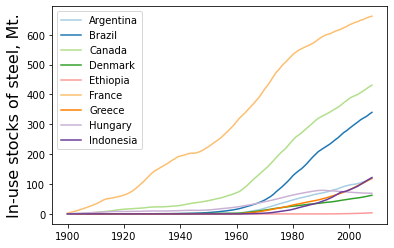

In [13]:
plt.set_loglevel("info") 
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
for m in range(0,len(MyRegions)):
    ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
            Dyn_MFA_System.StockDict['S_1'].Values[:,:,m,0].sum(axis =1)/1000, 
            color = MyColorCycle[m,:])
ax.set_ylabel('In-use stocks of steel, Mt.',fontsize =16)
ax.legend(MyRegions, loc='upper left',prop={'size':10})

We then plot the ratio of outflow over inflow, which is a measure of the stationarity of a stock, and can be interpreted as one indicator for a 'circular economy'.

<ipython-input-14-25ec9b7ca822>:3: RuntimeWarning: divide by zero encountered in true_divide
  FlowRatio = Dyn_MFA_System.FlowDict['F_1_0'].Values[:,:,:,0].sum(axis =1) \
<ipython-input-14-25ec9b7ca822>:3: RuntimeWarning: invalid value encountered in true_divide
  FlowRatio = Dyn_MFA_System.FlowDict['F_1_0'].Values[:,:,:,0].sum(axis =1) \


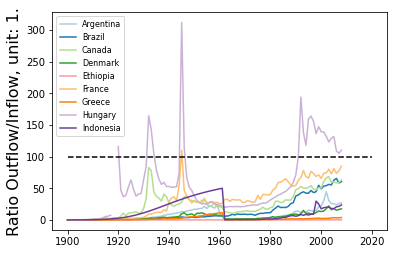

In [14]:
plt.set_loglevel("info") 

FlowRatio = Dyn_MFA_System.FlowDict['F_1_0'].Values[:,:,:,0].sum(axis =1) \
    / Dyn_MFA_System.FlowDict['F_0_1'].Values[:,:,0]
    
FlowRatio[np.isnan(FlowRatio)] = 0  # Set all ratios where reference flow F_0_1 was zero to zero, not nan.  

fig, ax = plt.subplots()
for m in range(0,len(MyRegions)):
    ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
            FlowRatio[:,m] * 100, color = MyColorCycle[m,:])
ax.plot([1900,2020],[100,100], color = 'k',linestyle = '--')
ax.set_ylabel('Ratio Outflow/Inflow, unit: 1.',fontsize =16)
ax.legend(MyRegions, loc='upper left',prop={'size':8})

We see that for the rich countries France and Canada the share has been steadily growing since WW2. Upheavals such as wars and major economic crises can also be seen, in particular, for Hungary.

### 8) Save data and results
Save entire system: 

In [15]:
pickle.dump( {'MFATestSystem': Dyn_MFA_System}, open( "Tutorial3_MFATestSystem.p", "wb" ) )